# codes no longer used but I dont wanna delete them 

# Simplified PAM

In [ ]:
def light_simulation(
    s,
    y0,
    high_light=1200,
    low_light=40,
    t_low_light=120,
    t_high_light=30,
    n_light_switches=5,
    t_pre=None,
    t_post=None,
):
    """Start with initial illumination at low light, then
    for n_light_switches
        simulate for t_high_light @ high_light
        simulate for t_low_light @ low_light
    """
    s.initialise(y0)
    s.update_parameter("pfd", low_light)
    if t_pre is None:
        t_end = 0
    else:
        t_end = t_pre
        s.simulate(t_end)
    for _ in tqdm(range(n_light_switches)):
        # High light
        t_end += t_high_light
        s.update_parameter("pfd", high_light)
        s.simulate(t_end)
        # Low light
        t_end += t_low_light
        s.update_parameter("pfd", low_light)
        s.simulate(t_end)
    if t_post is not None:
        t_end += t_post
        s.simulate(t_end)
    return s.get_full_results_df(), s.get_fluxes_df()


def plot_grid(df, items, ncol=3, col_width=4, row_height=3):
    nrow = math.ceil(len(items) / ncol)
    fig, axs = plt.subplots(nrow, ncol, figsize=(col_width * ncol, row_height * nrow))
    for item, ax in zip(items, axs.ravel()):
        try:
            df.loc[:, item].plot(ax=ax)
        except KeyError:
            item = df.columns.intersection(item)
            if len(item) > 0:
                df.loc[
                    :,
                ].plot(ax=ax)
    fig.tight_layout()
    return fig, axs

def annotate_light(s, axs):
    if not isinstance(axs, (list, np.ndarray)):
        axs = [axs]
    lights = [i["pfd"] for i in s.simulation_parameters]
    times = [(i[0], i[-1]) for i in s.time]
    max_pfd = max(lights)
    for ax in np.array(axs).flatten():
        for pfd, (t_start, t_end) in zip(lights, times):
            x = t_start
            #             x = (t_end - t_start) / 2
            #             x, _ = ax.transData.transform((x, 0))
            #             x, _ = ax.transData.inverted().transform((x, 0))
            ax.annotate(str(pfd), (x, 0.1), xycoords="data", ha="left")

In [ ]:
s = Simulator(m)
s.initialise(y0)
c, v = light_simulation(
    s,
    y0,
    high_light=1200,
    low_light=40,
    t_high_light=60,
    t_low_light=60,
    n_light_switches=5,
)

100%|██████████| 5/5 [00:16<00:00,  3.30s/it]


In [ ]:
c = checkpoint("c", f"{model}/{analysis}", "c", overwrite=True) 
v = checkpoint("v", f"{model}/{analysis}", "v", overwrite=True)

Overwritten: data/cyclic_2021_ODE/PAM\c.joblib,  (backup created at data/cyclic_2021_ODE/PAM\backup_c.joblib)
Overwritten: data/cyclic_2021_ODE/PAM\v.joblib,  (backup created at data/cyclic_2021_ODE/PAM\backup_v.joblib)


## plot fluorescence from stst. script

In [ ]:
# ELECTRON CARRIERS
ctmp = c

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.plot(ctmp["Fluo"], label="fluo", color=colors[0])

ax2.plot(ctmp["Q"], label="Q", color=colors[1])

# Set labels and legends
ax1.set(title="Fluorescence",
        xlabel="PFD",
        ylabel="")
ax2.set_ylabel("metabolite concentration")

# Legends
ax1.legend(loc="upper left", bbox_to_anchor=(0.06, 1))
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.1))

In [ ]:
def get_minmax(s,T_END):
    c = s.get_full_results_df()
    v = s.get_fluxes_df()
    
    cmin = c.loc[T_END*0.75:,:].min()
    cmax = c.loc[T_END*0.75:,:].max()
    vmin = v.loc[T_END*0.75:,:].min()
    vmax = v.loc[T_END*0.75:,:].max()
    
    return cmin, cmax, vmin, vmax

In [ ]:
def get_avg(s, T_END):
    """
    Compute the average values of concentrations and fluxes over the last 25% of the simulation time.
    """
    
    c = s.get_full_results_df()
    v = s.get_fluxes_df()
    
    # Compute the average fluxes over the last 25% of the simulation
    vavg = pd.Series(
        integrate.trapezoid(
            v.loc[T_END*0.75:,:],  # Select the last 25% of the time range
            x=v.loc[T_END*0.75:,:].index,  # Use time as the x-axis
            axis=0
        ) / (T_END - v.loc[T_END*0.75:,:].index.min()),  # Normalize by time range
        index=v.columns  # Assign column names
    )

    # Compute the average concentrations over the last 25% of the simulation
    cavg = pd.Series(
        integrate.trapezoid(
            c.loc[T_END*0.75:,:],  # Select the last 25% of the time range
            x=c.loc[T_END*0.75:,:].index,  # Use time as the x-axis
            axis=0
        ) / (T_END - v.loc[T_END*0.75:,:].index.min()),  # Normalize by time range
        index=c.columns  # Assign column names
    )

    return cavg.T, vavg.T  # Return the transposed averages of concentrations and fluxes


## file: quick_test_PSII.ipynb

In [ ]:
# run the header that sets up the environment

if "already_run" not in globals():
    globals()["already_run"] = True
    
    %run header.ipynb
    load_packages()
    change_wordir()
    colors, colours = colourblind_palette()

#model = "cyclic_2021"
#model = "new_PSI"
model = "latest_dev"

m = load_model(model)


succesfully loaded latest_dev :D


In [ ]:

def pfd_ss_scan(s: object, pfd_values: np.ndarray, y0_loop: dict, debug: bool =False) -> tuple:

    fluxes = {}  # store steady-state fluxes for each pfd value
    concentrations = {}  # store steady-state concentrations for each pfd value
    failed_cases = []

    # Iterate over each pfd value with a progress bar
    for x in tqdm(pfd_values, total=len(pfd_values)):  

        s.initialise(y0_loop)  # Reset the system with the given initial conditions
        s.update_parameter("pfd", x)  # Update the parameter "pfd" to the current value
        
        try:
            t, y = s.simulate_to_steady_state()

            if y is None or len(y) == 0:  # Check for invalid output
                raise ValueError(f"Simulation returned empty result at pfd={x}")

            # Store the final steady-state concentrations
            concentrations[x] = s.get_full_results_array()[-1]

            # Store the final steady-state fluxes
            fluxes[x] = s.model.get_fluxes_array(y=y, t=t)[-1]

            # Update initial conditions for the next iteration
            y0_loop = s.get_new_y0()

        except Exception as e:
            logger.warning(f"Simulation failed at pfd={x}: {e}")
            failed_cases.append(x)

            # Store NaNs for failed cases
            all_compounds = s.model.get_all_compounds()
            rate_names = s.model.get_rate_names()
            concentrations[x] = np.full(len(all_compounds), np.nan)
            fluxes[x] = np.full(len(rate_names), np.nan)

            # If debug mode is enabled, log additional details
            if debug:
                logger.debug(f"Failed pfd={x}. Initial conditions: {y0_loop}")

    # Log summary after execution
    logger.info(f"Simulation completed. {len(failed_cases)} cases failed: {failed_cases}")

    return (
        pd.DataFrame(concentrations, index=s.model.get_all_compounds()).T,  # Convert concentration results to DataFrame
        pd.DataFrame(fluxes, index=s.model.get_rate_names()).T  # Convert flux results to DataFrame
    )


In [ ]:
NUM_SCANS = 5
LOW_LIGHT = 40
HIGH_LIGHT = 1750
PFD_VALUES = np.linspace(LOW_LIGHT, HIGH_LIGHT, NUM_SCANS)

y0 = {
    "PQ": 11.248282037382348,       "PC": 1.3639930534269078,       "Fd": 4.207984023619571,
    "ATP": 1.6085042256522668,      "NADPH": 0.45672250689837696,   "H": 0.002174958602661375,
    "LHC": 0.8079188314632375,      "Psbs": 0.9626375680773129,     "Vx": 0.9570474456930378,
    "PGA": 0.6109221284988471,      "BPGA": 0.0003235574325883373,  "GAP": 0.003190323205250446,
    "DHAP": 0.07018710225866034,    "FBP": 0.0015898274733035427,   "F6P": 0.0886998278393475,
    "G6P": 0.20400960399249862,     "G1P": 0.011832557030606641,    "SBP": 0.003215008299488195,
    "S7P": 0.02811069161049136,     "E4P": 0.003523560381569699,    "X5P": 0.006746131132013272,
    "R5P": 0.011299769265221232,    "RUBP": 0.030373422172205858,   "RU5P": 0.004519907641254276,
    "MDA": 2.2718326276618075e-06,
#    "ASC": 9.999997726884683,
    "H2O2": 1.3296482521160688e-06,
    "DHA": 1.2828228406972059e-09,
#    "GSH": 9.999999998752703,
    "GSSG": 6.236645512101874e-10,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
    "P700FA": 1.4731,            #eq at pfd 800       #"PSItot": 2.5, (in parameter vector of Matuszynska)
    "P700+FA-": 0.0131,
    "P700FA-": 0.0177,
    "B0": 1,
    "B1": .25,
    "B2": 1,
}

I do suspect oscillations to hinder/prevent the st.st. analysis. lets check

In [ ]:
s = Simulator(m)

s.initialise(y0)  # Initialize the simulator with the initial conditions
s.update_parameter("pfd", 800)  # Set the initial PFD value

s.simulate(5000)
print("")


700, 900 (ganz wild), 925, 

<Axes: >

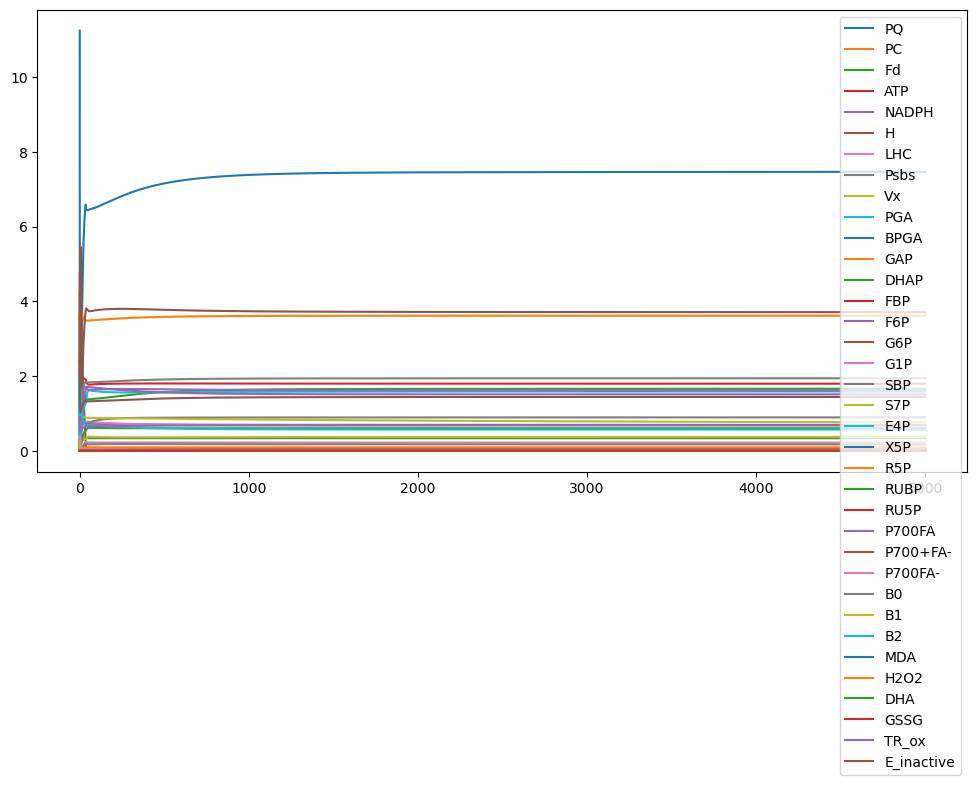

In [ ]:
s.get_results_df().plot(figsize = (12,6))

In [ ]:
s = Simulator(m)
c, v = pfd_ss_scan(s, PFD_VALUES, y0, True)

100%|██████████| 5/5 [00:08<00:00,  1.64s/it]
2025-04-09 13:03:55,144 - INFO - Simulation completed. 0 cases failed: []


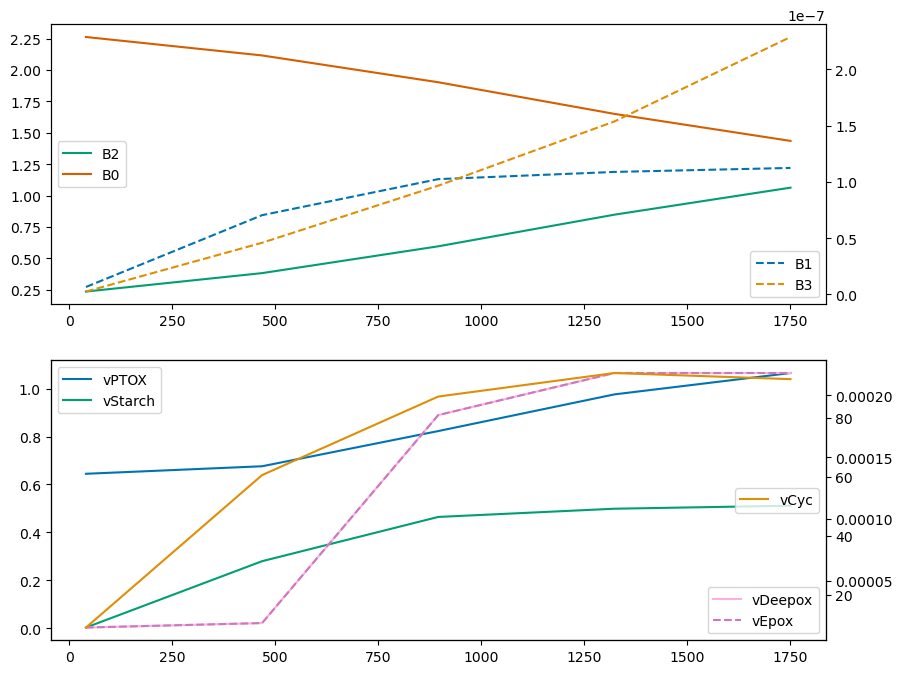

In [ ]:
# PSII states in st.st.

fig, (ax11, ax21) = plt.subplots(2,1,figsize=(10, 8))
ax12 = ax11.twinx()
#ax13 = ax11.twinx()
ax22 = ax21.twinx()
ax23 = ax21.twinx()

ax12.plot(c.loc[:, "B1"], label = "B1", color=colors[0], linestyle='--')
ax12.plot(c.loc[:, "B3"], label = "B3", color=colors[1], linestyle='--')
ax11.plot(c.loc[:, "B2"], label = "B2", color=colors[2])
ax11.plot(c.loc[:, "B0"], label = "B0", color=colors[3])

# vPTOX, vCyc, vStarch, vDeepox, vEpox

ax21.plot(v.loc[:, "vPTOX"], label = "vPTOX", color=colors[0])
ax23.plot(v.loc[:, "vCyc"], label = "vCyc", color=colors[1])
ax21.plot(v.loc[:, "vStarch"], label = "vStarch", color=colors[2])
ax22.plot(v.loc[:, "vDeepox"], label = "vDeepox", color=colors[6], linestyle='-')
ax22.plot(v.loc[:, "vEpox"], label = "vEpox", color=colors[4], linestyle='--')

ax11.legend(loc='center left')
ax12.legend(loc='lower right')
ax21.legend(loc='upper left')
ax22.legend(loc='lower right')
ax23.legend(loc='center right')

plt.show()


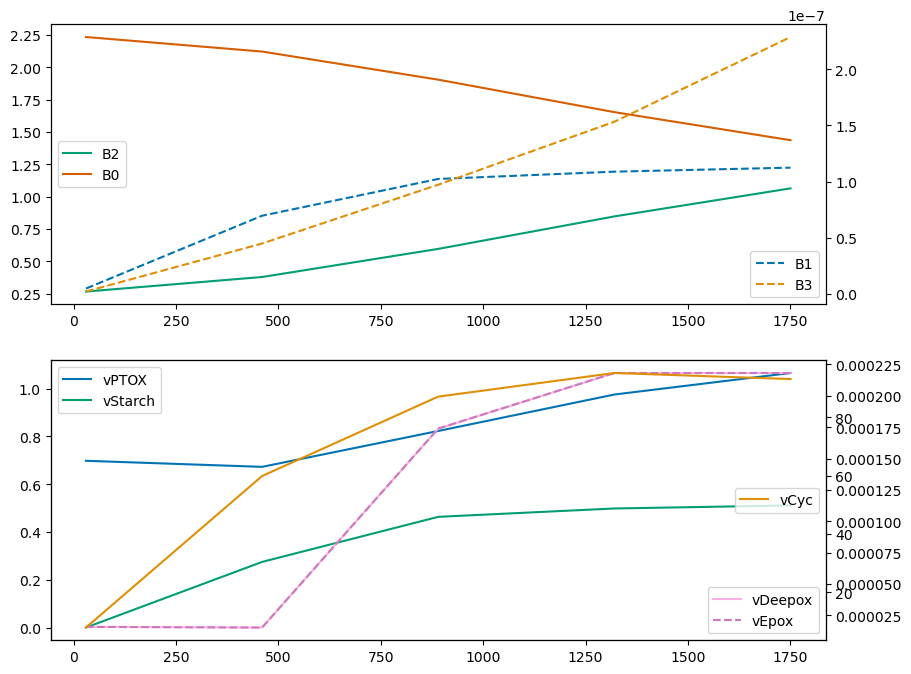

In [ ]:
from IPython.display import Image
Image(filename='figures/new_PSI/PSII.png') 

In [ ]:
from modelbase.ode import Model
p = {"a": 0.5, "b":1}
m = Model(parameters=p, compounds=["A", "B"])

In [ ]:
def power(A, a):
    return a**A

def plus3(x):
    return 1

In [ ]:
m.add_reaction(
    rate_name="1",
    function=power,
    stoichiometry={"A": 1},
    args={"A", "a"}
)

# m.add_algebraic_module(
#     module_name="X",
#     function=times,
#     compounds=["A"],
#     derived_compounds=["X"],
#     parameters=["a"],
#     args=["a", "A"]
# )

# m.add_algebraic_module(
#     module_name="Y",
#     function=times,
#     compounds=["X"],
#     derived_compounds=["Y"],
#     parameters=["a"],
# )


<Axes: >

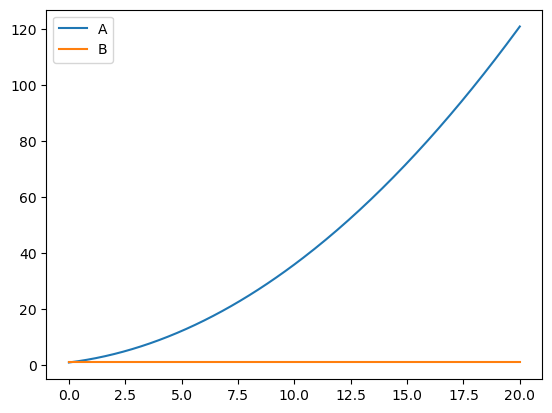

In [ ]:
from modelbase.ode import Simulator

s = Simulator(m)
s.initialise({"A":1, "B":1})
t_end = 20
steps_per_second = 10

steps = steps_per_second * t_end

_ = s.simulate(t_end = t_end, steps = steps)
s.get_full_results_df().plot()